# Импорт модулей

In [1]:
import os

import pandas as pd

import matplotlib.pyplot as plt
import skimage as sk
from PIL import Image

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
import keras.layers as layers

# Загрузка файлов

Введем константы

In [2]:
IMG_SIZE = (160, 160)

INPUT_DIR = './images_160/images/'
TARGET_DIR = './images_160/segments/'
INPUT_BACK = './images_160/background/'

RESEARCH_DIR = './images_research/'

NUM_CLASSES = 3
LABEL_SHELL = '_SHELL'
LABEL_CORE = '_CORE'

SEED = 5115

MODEL_UNET = 'model_unet_220905.h5'
HISTORY_UNET = 'history_unet_220905.csv'

TEST_SPLIT = 0.2
VAL_SPLIT = 0.25
EPOCHS = 2000
BATCH_SIZE = None

Создадим списки с названиями исследуемых изображений и разметки.

In [3]:
input_paths = sorted(
    [os.path.join(INPUT_DIR, file_name)
     for file_name in os.listdir(INPUT_DIR)
     if file_name.endswith('.jpg')])

target_paths = sorted(
    [os.path.join(TARGET_DIR, file_name)
     for file_name in os.listdir(TARGET_DIR)
     if file_name.endswith('.png')])

print('Количество изображений:', len(input_paths))
print('Количество файлов разметки:', len(target_paths))
for i in range(5):
    print(input_paths[i], '|', target_paths[i])

Количество изображений: 132
Количество файлов разметки: 253
./images_160/images/ETD_1_001_1.jpg | ./images_160/segments/ETD_1_001_1_CORE.png
./images_160/images/ETD_1_001_2.jpg | ./images_160/segments/ETD_1_001_1_SHELL.png
./images_160/images/ETD_1_001_3.jpg | ./images_160/segments/ETD_1_001_2_CORE.png
./images_160/images/ETD_1_002_1.jpg | ./images_160/segments/ETD_1_001_2_SHELL.png
./images_160/images/ETD_1_002_2.jpg | ./images_160/segments/ETD_1_001_3_CORE.png


Создадим массив изображений.

In [4]:
def files_to_arrays(input_dir, target_dir=False, random_seed=None):

    input_img_paths = [os.path.join(input_dir, file_name)
                       for file_name in os.listdir(input_dir)
                       if file_name.endswith('.jpg')]
    random.Random(random_seed).shuffle(input_img_paths)

    X_list = []
    for i in input_img_paths:
        image = plt.imread(i)
        image = sk.color.rgb2gray(image)
        X_list.append(image)
    X = np.array(X_list).astype('float64')
    X = np.expand_dims(X, 3)

    if target_dir:
        target_img_paths = [os.path.join(target_dir, file_name)
                            for file_name in os.listdir(target_dir)
                            if file_name.endswith('.png')]

        y_list = []
        for i in input_img_paths:
            input_name = i.replace(input_dir, '').replace('.jpg', '')
            target_array = np.zeros(IMG_SIZE + (2,))
            target_array = np.insert(target_array, 0, np.ones(IMG_SIZE), axis=2)

            for j in target_img_paths:
                target_name = j.replace(target_dir, '').replace('.png', '')
                if target_name.endswith(LABEL_SHELL) and (target_name.replace(LABEL_SHELL, '') == input_name):
                    target_array[:,:,1] += plt.imread(j)
                elif target_name.endswith(LABEL_CORE) and (target_name.replace(LABEL_CORE, '') == input_name):
                    target_array[:,:,2] += plt.imread(j)

            mask_background = np.logical_and(np.logical_or(target_array[:,:,1], target_array[:,:,2]),
                                             target_array[:,:,0])
            target_array[:,:,0] *= np.logical_not(mask_background)

            mask_metal = np.logical_and(target_array[:,:,1], target_array[:,:,2])
            target_array[:,:,2] *= np.logical_not(mask_metal)

            target_array = np.ceil(target_array).astype('uint8')
            y_list.append(target_array)
        y = np.array(y_list)

    else:
        y_list = []
        for _ in input_img_paths:
            target_array = np.zeros(IMG_SIZE + (2,))
            target_array = np.insert(target_array, 0, np.ones(IMG_SIZE), axis=2)
            target_array = target_array.astype('uint8')
            y_list.append(target_array)
        y = np.array(y_list)

    return X, y

In [5]:
def array_info(X, y):
    print('Размер массива изображений:', X.shape)
    print('Min X =', X.min(), '|', 'Max X =', X.max())
    print('Размер массива разметки:', y.shape)
    print('Min y =', y.min(), '|', 'Max y =', y.max())
    print('Уникальные значения y:', np.unique(y))
    print('Количество попарных пересечений между классами разметки:',
          np.logical_and(y[..., 0], y[..., 1]).sum() +
          np.logical_and(y[..., 0], y[..., 2]).sum() +
          np.logical_and(y[..., 1], y[..., 2]).sum())

Загрузим файлы в массив и перемешаем их.

In [6]:
X_1, y_1 = files_to_arrays(INPUT_DIR, TARGET_DIR, random_seed=SEED)
X_back_1, y_back_1 = files_to_arrays(INPUT_BACK, random_seed=SEED)

X = np.concatenate([X_1, X_back_1], axis=0)
y = np.concatenate([y_1, y_back_1], axis=0)

np.random.seed(SEED + 1)
array_ind = np.random.choice(range(X.shape[0]), X.shape[0], replace=False)

X = X[array_ind]
y = y[array_ind]

array_info(X, y)

Размер массива изображений: (209, 160, 160, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (209, 160, 160, 3)
Min y = 0 | Max y = 1
Уникальные значения y: [0 1]
Количество попарных пересечений между классами разметки: 0


Разделим полученный массив на тренировочную и тестовую выборки.

In [7]:
test_size = int(X.shape[0] * TEST_SPLIT)

X_train = X[:-test_size]
y_train = y[:-test_size]

X_test = X[-test_size:]
y_test = y[-test_size:]

print('Количество изображений в тренировочном массиве:', X_train.shape[0])
print('Количество изображений в тестовом массиве:', X_test.shape[0])

Количество изображений в тренировочном массиве: 168
Количество изображений в тестовом массиве: 41


# Аугментация

Добавим повороты изображений.

In [8]:
def rotation_and_crop(X_train, y_train, rotate_angle, crop_size):

    X_list = []
    y_list = []

    for i in range(X_train.shape[0]):

        X_img = Image.fromarray(X_train[i, :, :, 0])
        X_rcz = X_img.rotate(angle=rotate_angle)\
                 .crop(box=(crop_size,
                            crop_size,
                            IMG_SIZE[0] - crop_size,
                            IMG_SIZE[1] - crop_size))\
                 .resize(size=IMG_SIZE)

        X_rcz_array = np.array(X_rcz)
        X_rcz_array = np.where(X_rcz_array < 0, 0, X_rcz_array)
        X_rcz_array = np.where(X_rcz_array > 1, 1, X_rcz_array)
        X_rcz_array_dims = np.expand_dims(X_rcz_array, (0, 3))

        X_list.append(X_rcz_array_dims)

        y_img = Image.fromarray(y_train[i, :, :, :])
        y_rcz = y_img.rotate(angle=rotate_angle)\
                 .crop(box=(crop_size,
                            crop_size,
                            IMG_SIZE[0] - crop_size,
                            IMG_SIZE[1] - crop_size))\
                 .resize(size=IMG_SIZE)

        y_rcz_array = np.array(y_rcz)
        y_rcz_array = np.where(y_rcz_array < 0, 0, y_rcz_array)
        y_rcz_array = np.where(y_rcz_array > 1, 1, y_rcz_array)
        y_rcz_array_dims = np.expand_dims(y_rcz_array, 0)

        y_list.append(y_rcz_array_dims)

    X_aug = np.concatenate(X_list, axis=0)
    y_aug = np.concatenate(y_list, axis=0)

    return X_aug, y_aug

Создадим массив с поворотами изображений, размер которого равен размеру тренировочного массива.

In [9]:
X_rot_45, y_rot_45 = rotation_and_crop(X_train, y_train, 45, 40)
X_rot_135, y_rot_135 = rotation_and_crop(X_train, y_train, 135, 40)
X_rot_225, y_rot_225 = rotation_and_crop(X_train, y_train, 225, 40)

X_rot_90, y_rot_90 = rotation_and_crop(X_train, y_train, 90, 10)
X_rot_180, y_rot_180 = rotation_and_crop(X_train, y_train, 180, 10)
X_rot_270, y_rot_270 = rotation_and_crop(X_train, y_train, 270, 10)

X_rot = np.concatenate([X_rot_45, X_rot_135, X_rot_225,
                        X_rot_90, X_rot_180, X_rot_270], axis=0)
y_rot = np.concatenate([y_rot_45, y_rot_135, y_rot_225,
                        y_rot_90, y_rot_180, y_rot_270], axis=0)

np.random.seed(SEED + 2)
rot_ind = np.random.choice(range(X_rot.shape[0]), X_train.shape[0], replace=False)

X_rot = X_rot[rot_ind]
y_rot = y_rot[rot_ind]

Соединим исходный тренировочный и измененный массивы, после чего перемешаем их.

In [10]:
X_train_aug = np.concatenate([X_train, X_rot], axis=0)
y_train_aug = np.concatenate([y_train, y_rot], axis=0)

np.random.seed(SEED + 3)
random_ind = np.random.choice(range(X_train_aug.shape[0]), X_train_aug.shape[0], replace=False)

X_train_aug = X_train_aug[random_ind]
y_train_aug = y_train_aug[random_ind]

array_info(X_train_aug, y_train_aug)

Размер массива изображений: (336, 160, 160, 1)
Min X = 0.0 | Max X = 1.0
Размер массива разметки: (336, 160, 160, 3)
Min y = 0 | Max y = 1
Уникальные значения y: [0 1]
Количество попарных пересечений между классами разметки: 0


Проверим соответствие массивов изображений и разметки.

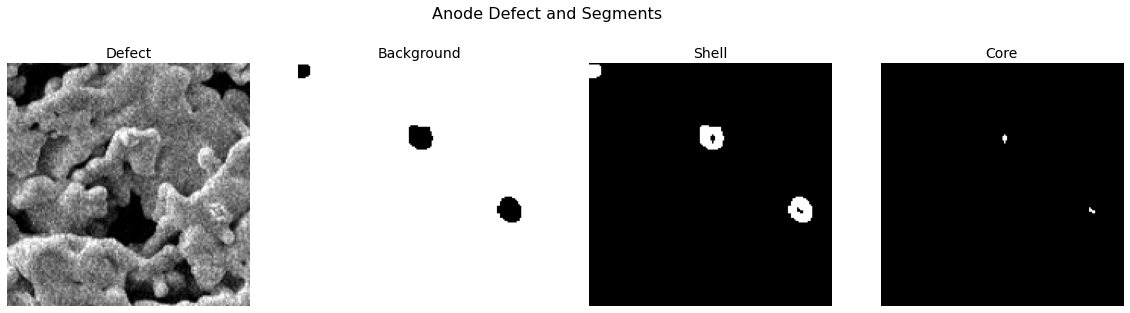

Defect Area on Segments (pixels):
Background: 25109
Shell: 470
Core: 21


In [11]:
# idx = 5
np.random.seed(None)
idx = np.random.randint(X_train_aug.shape[0])

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 10))

ax[0].imshow(X_train_aug[idx], cmap='gray')
ax[0].set_title('Defect', size=14)
ax[0].axis('off')

for i, j in zip(range(1, 4), ['Background', 'Shell', 'Core']):
    ax[i].imshow(y_train_aug[idx, :, :, i - 1], cmap='gray')
    ax[i].set_title(j, size=14)
    ax[i].axis('off')

fig.suptitle('Anode Defect and Segments', size=16, y=0.75)
plt.show()

print('Defect Area on Segments (pixels):')
for j1, j2 in zip(['Background:', 'Shell:', 'Core:'], range(3)):
    print(j1, y_train_aug[idx,:,:,j2].sum())

# Подготовка модели

In [12]:
def get_unet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))
    # Down 1
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    # Down 2
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Dropout(0.2)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    # Down 3
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Dropout(0.2)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    # Down 4
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Dropout(0.2)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    # Bottleneck
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Dropout(0.2)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    # Up 1
    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Dropout(0.2)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    # Up 2
    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    # Up 3
    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    conv8 = layers.Dropout(0.2)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation('relu')(conv8)
    # Up 4
    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    conv9 = layers.Dropout(0.2)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation('relu')(conv9)
    # Output
    conv10 = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(conv9)

    model_unet = keras.Model(inputs=[inputs], outputs=[conv10])

    return model_unet

keras.backend.clear_session()

model_unet = get_unet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Тренировка модели

In [13]:
# model_unet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
#                    loss="categorical_crossentropy",
#                    metrics=[tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)])
#
# callbacks_unet = [keras.callbacks.ModelCheckpoint(MODEL_UNET, save_best_only=True)]
#
# history_unet = model_unet.fit(X_train_aug, y_train_aug,
#                     callbacks=callbacks_unet,
#                     epochs=EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     validation_split=VAL_SPLIT,
#                     verbose=1,
#                     shuffle=True)
#
# hist_unet_df = pd.DataFrame(history_unet.history)
# hist_unet_df.to_csv(HISTORY_UNET, index=False)

# История обучения

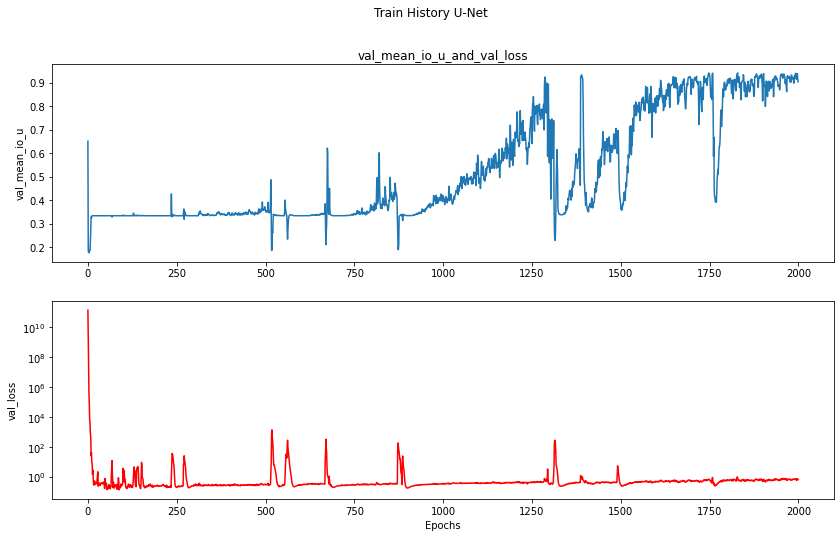

In [14]:
hist_unet_df = pd.read_csv(HISTORY_UNET)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

ax[0].plot(hist_unet_df[hist_unet_df.columns[-1]])
ax[0].set_title('_and_'.join([hist_unet_df.columns[-1], hist_unet_df.columns[-2]]))
ax[0].set_ylabel(hist_unet_df.columns[-1])

ax[1].plot(hist_unet_df[hist_unet_df.columns[-2]], 'r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel(hist_unet_df.columns[-2])
ax[1].set_yscale('log')

plt.suptitle('Train History U-Net')
plt.show()

# Предсказание

In [15]:
best_unet = keras.models.load_model(MODEL_UNET)

test_results = best_unet.evaluate(X_test, y_test, verbose=0)
print('X_test - Mean_I_o_U:', round(test_results[1], 2))
print('X_test - Loss:', round(test_results[0], 2))

y_prob = best_unet.predict(X_test, verbose=0)
print('Shape of y_pred:', y_prob.shape)

X_test - Mean_I_o_U: 0.33
X_test - Loss: 0.09
Shape of y_pred: (41, 160, 160, 3)


In [16]:
for i1, i2 in zip(['Максимальные значения по каналам:',
                   'Медианные значения по каналам:',
                   'Минимальные значения по каналам:'], range(3)):
    if i2 > 0:
        print()
    print(i1, end=' ')
    for j in range(3):
        if i2 == 0:
            print(np.max(y_prob[..., j]), end=' ')
        elif i2 == 1:
            print(np.median(y_prob[..., j]), end=' ')
        elif i2 == 2:
            print(np.min(y_prob[..., j]), end=' ')

Максимальные значения по каналам: 0.9999924 0.9946563 0.9999987 
Медианные значения по каналам: 0.9998683 0.00011871263 1.3378925e-05 
Минимальные значения по каналам: 5.389421e-14 1.3541998e-06 3.3090143e-07 

Функция для определения канала с максимальной вероятностью.

In [17]:
def proba_to_argmax(y_proba):

    y_zeros = np.zeros(y_proba.shape)
    y_argmax = np.argmax(y_proba, axis=3)

    for chanel in range(y_proba.shape[-1]):
        y_zeros[..., chanel] += np.where(y_argmax == chanel, 1, 0)

    y_proba_to_argmax = y_zeros.astype('uint8')

    return y_proba_to_argmax

In [18]:
y_pred = y_prob.copy()
y_pred = proba_to_argmax(y_pred)

Посмотрим как модель определяет дефекты.

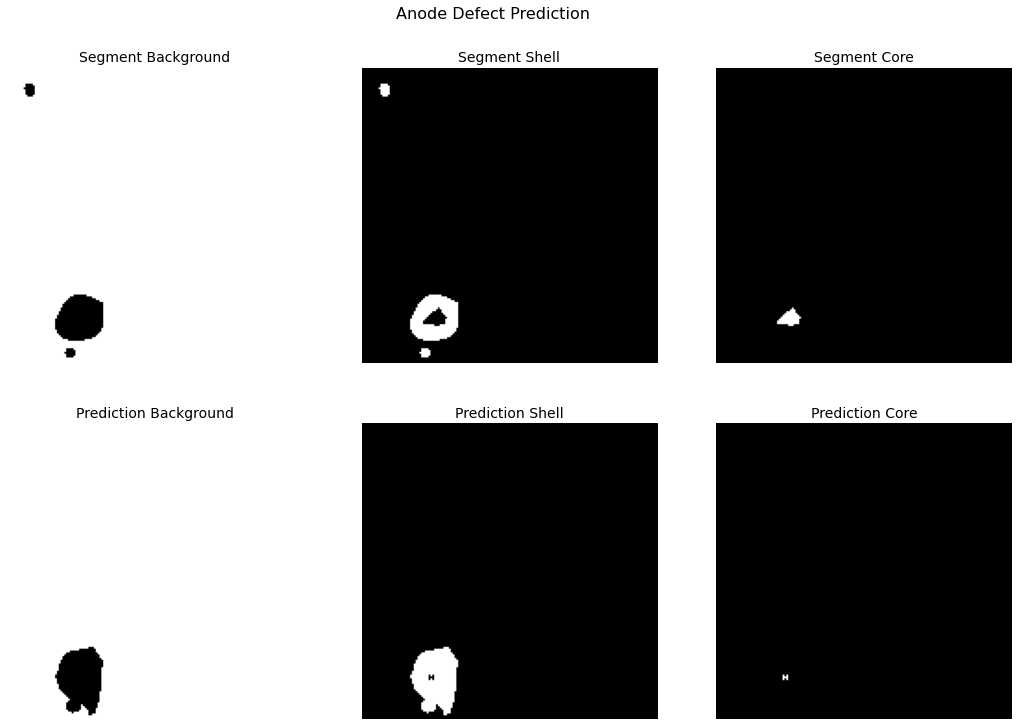

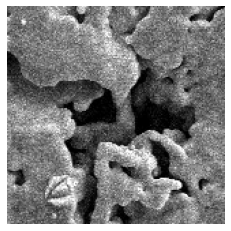

Defect Area on Segments (pixels):
Background: 25015
Shell: 511
Core: 74

Defect Area on Prediction (pixels):
Background: 24911
Shell: 682
Core: 7



In [19]:
# idx_test = 0
np.random.seed(None)
idx_test = np.random.randint(X_test.shape[0])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,12))

for i1, i2, i3 in zip(range(2), [y_test, y_pred], ['Segment', 'Prediction']):
    for j1, j2 in zip(range(3), ['Background', 'Shell', 'Core']):
        ax[i1, j1].imshow(i2[idx_test,:,:,j1], cmap='gray')
        ax[i1, j1].set_title(' '.join([i3, j2]), size=14)
        ax[i1, j1].axis('off')
fig.suptitle("Anode Defect Prediction", size=16, y=0.95)
plt.show()

plt.imshow(X_test[idx_test], cmap='gray')
plt.axis('off')
plt.show()

for i1, i2 in zip(['Defect Area on Segments (pixels):',
                   'Defect Area on Prediction (pixels):'],
                  [y_test, y_pred]):
    print(i1)
    for j1, j2 in zip(['Background:', 'Shell:', 'Core:'], range(3)):
        print(j1, i2[idx_test,:,:,j2].sum())
    print()

# Использование модели

In [20]:
def research_anode_defects(file_path, dl_model, hfw_mkm):

    research_image = plt.imread(file_path)
    # обрезаем информацию об увеличении
    research_image = research_image[:1010]
    research_image = research_image / research_image.max()

    # увеличиваем, чтобы скользящее окно умещалось целое количество раз
    add_axis0 = IMG_SIZE[0] - research_image.shape[0] % IMG_SIZE[0]
    add_axis1 = IMG_SIZE[1] - research_image.shape[1] % IMG_SIZE[1]

    image_wide = np.insert(research_image, -1, np.zeros((add_axis0, research_image.shape[1])), axis=0)
    image_wide = np.insert(image_wide, -1, np.zeros((add_axis1, image_wide.shape[0])), axis=1)

    new_image = np.zeros((1,) + image_wide.shape + (NUM_CLASSES,))
    image_wide_dims = np.expand_dims(image_wide, (0,3))

    for i in range(image_wide.shape[0] // IMG_SIZE[0]):
        for j in range(image_wide.shape[1] // IMG_SIZE[1]):
            new_image[:, i * IMG_SIZE[0]:(i + 1) * IMG_SIZE[0],
                         j * IMG_SIZE[1]:(j + 1) * IMG_SIZE[1], :] += \
            dl_model.predict(image_wide_dims[:, i * IMG_SIZE[0]:(i + 1) * IMG_SIZE[0],
                          j * IMG_SIZE[1]:(j + 1) * IMG_SIZE[1], :], verbose=0)

    research_predict = proba_to_argmax(new_image)

    result = research_predict[0, ...]
    result = result[:research_image.shape[0], :research_image.shape[1]]

    result_image = np.concatenate([np.expand_dims(research_image, 2),
                                  result[..., 1:]],
                                  axis=2)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,10))

    ax[0].imshow(research_image, cmap='gray')
    ax[0].set_title('Research Image', size=14)
    ax[0].axis('off')

    ax[1].imshow(result_image)
    ax[1].set_title('Segmentation', size=14)
    ax[1].axis('off')

    plt.show()

    print('FILE name:', file_path.replace(RESEARCH_DIR, ''))
    print('HFW (mkm):', hfw_mkm)
    print('IMAGE size:', result_image.shape[0:2])
    print('SHELL pixels number:', result_image[..., 1].sum().astype('int'))
    print('CORE pixels number:', result_image[..., 2].sum().astype('int'))

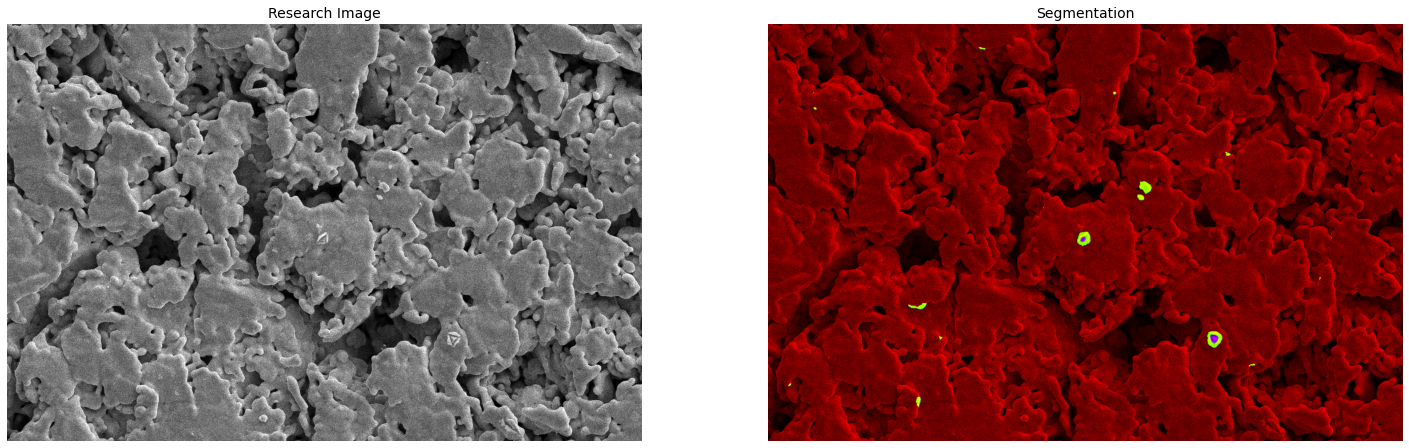

FILE name: ETD_1_002.tif
HFW (mkm): 150
IMAGE size: (1010, 1536)
SHELL pixels number: 3246
CORE pixels number: 421
Wall time: 34.3 s


In [21]:
%%time
research_anode_defects(''.join([RESEARCH_DIR, 'ETD_1_002.tif']), best_unet, hfw_mkm=150)

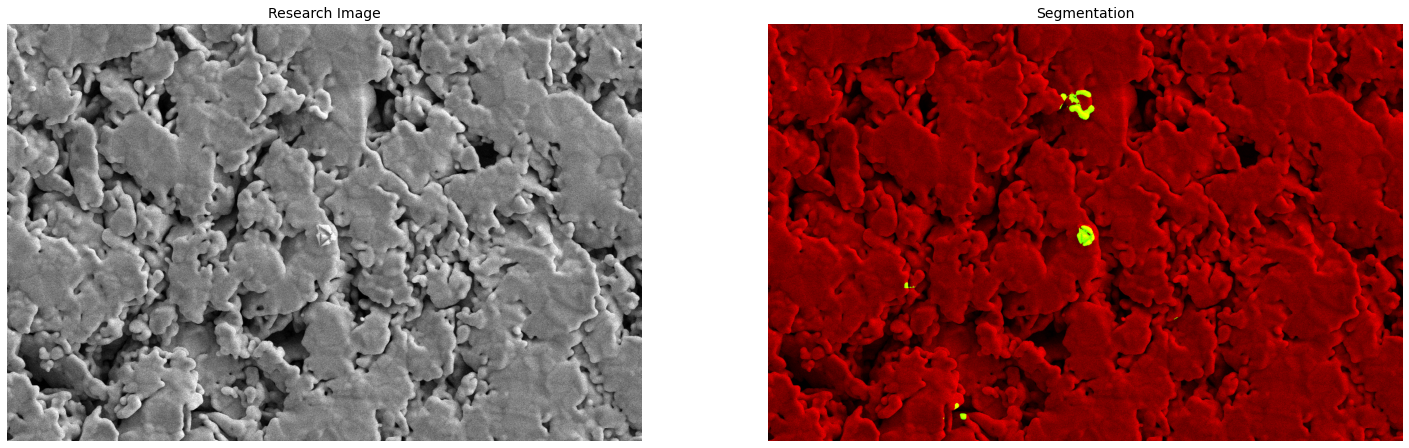

FILE name: ETD_2_026.tif
HFW (mkm): 150
IMAGE size: (1010, 1536)
SHELL pixels number: 4269
CORE pixels number: 0
Wall time: 32 s


In [22]:
%%time
research_anode_defects(''.join([RESEARCH_DIR, 'ETD_2_026.tif']), best_unet, hfw_mkm=150)